## Best Classifier for Fashion-MNIST Dataset

In [37]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay
import seaborn as sns

from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical   

seed = 1234
np.random.seed(seed) 

### Clean Data

In [38]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

x_tr = X_train.astype(int)
x_te = X_test.astype(int)

y_tr = y_train.astype(int)
y_te = y_test.astype(int)

X_fashion = np.concatenate([x_tr, x_te])
y_fashion = np.concatenate([y_tr, y_te])

X_tr, X_te, y_tr, y_te = train_test_split(X_fashion, y_fashion, test_size=0.20, random_state=seed, shuffle=True)

print(f"X_tr shape: {X_tr.shape}")
print(f"X_te shape: {X_te.shape}")

print(f"y_tr shape: {y_tr.shape}")
print(f"y_te.shape: {y_te.shape}")

X_tr shape: (56000, 28, 28)
X_te shape: (14000, 28, 28)
y_tr shape: (56000,)
y_te.shape: (14000,)


### Glimpse of Dataset

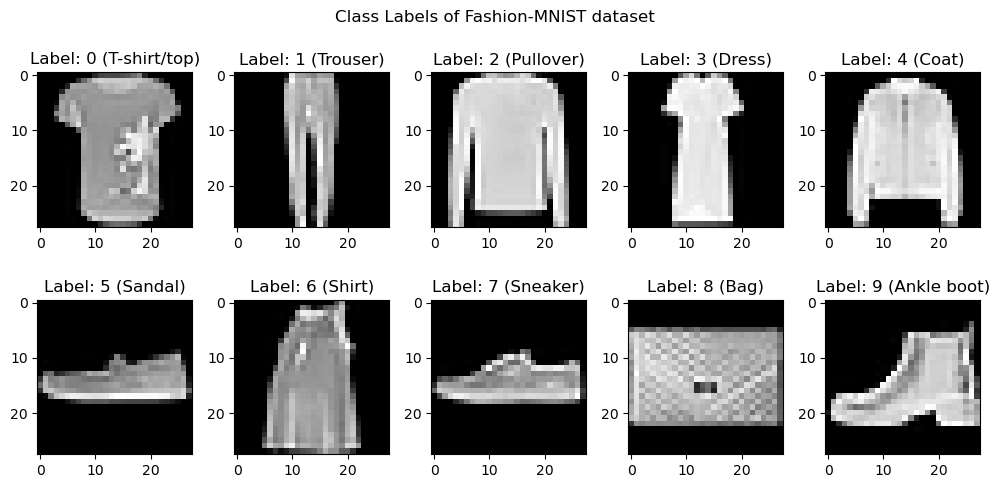

In [39]:
# Real Label

def find(arr, elem):
    for index, item in enumerate(arr):
        if item == elem:
            return index

TrueLabels = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 
              5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray' 
figure, axes = plt.subplots(2, 5, figsize=(10, 5))

i = 0
for x in range(2): 
    for y in range(5):
        index = find(y_tr, i)
        axes[x, y].imshow(X_tr[index]) 
        axes[x, y].set_title(f'Label: {i} ({TrueLabels[i]})') 
        i+= 1

plt.suptitle("Class Labels of Fashion-MNIST dataset")
plt.tight_layout() 

### Standardize and Set Up Validation Set

In [4]:
X_tr = np.reshape(X_tr, (56000,784))
X_te = np.reshape(X_te, (14000,784))

y_tr = y_tr.flatten()
y_te = y_te.flatten()

scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

X_val = X_tr[42000:]
y_val = y_tr[42000:]

X_tr = X_tr[:42000]
y_tr = y_tr[:42000]

### Make Confusion Matrix

In [28]:
def cm(y_pred, title):
    fig, ax = plt.subplots(figsize=(7, 5))

    sklearn_cm_eu = confusion_matrix(y_te, y_pred)
    sns.heatmap(sklearn_cm_eu, annot=True, ax=ax, fmt='g')

    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")

    ax.set_title(f"Confusion Matrix of Fashion-MNIST using {title}")
    return plt

### Nearest Centroid Classifier

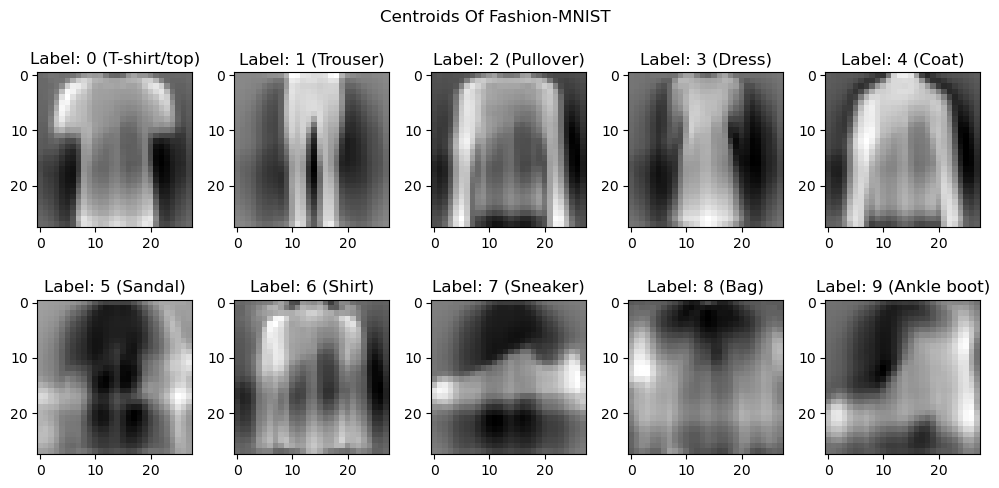

In [29]:
def plot_centroids(centroids):
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    
    for i in range(10):
        axes[i//5, i%5].imshow(centroids[i].reshape(28, 28))
        axes[i//5, i%5].set_title(f'Label: {i} ({TrueLabels[i]})')
    fig.suptitle("Centroids Of Fashion-MNIST")
    plt.tight_layout()
    plt.show()
nc = NearestCentroid().fit(X_tr, y_tr)
plot_centroids(nc.centroids_)

In [30]:
train_predict = nc.predict(X_tr)
val_predict = nc.predict(X_te)
test_predict = nc.predict(X_val)

results = {"Train Accuracy": [0], "Validation Accuracy": [0], "Test Accuracy": [0]}

results["Train Accuracy"][0] = accuracy_score(y_tr, train_predict)
results["Validation Accuracy"][0] = accuracy_score(y_val, val_predict)
results["Test Accuracy"][0] = accuracy_score(y_te, test_predict)

df_nc = pd.DataFrame(results)

df_nc

,Train Accuracy,Validation Accuracy,Test Accuracy
0,0.681024,0.098714,0.101071


In [40]:
df_nc.to_csv('./results/nc.csv', index=False)

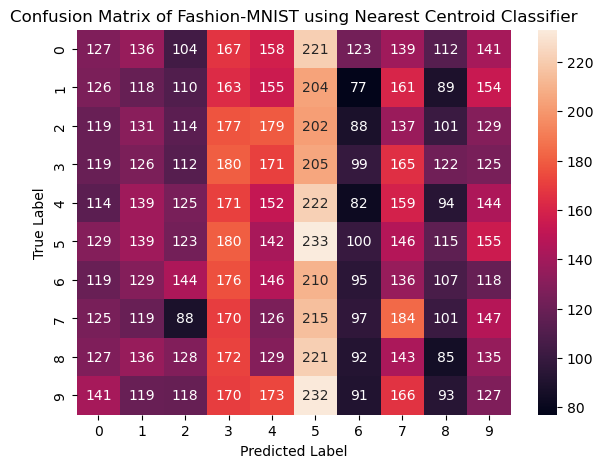

In [32]:
cm_knn = cm(test_predict, "Nearest Centroid Classifier")
cm_knn.show()

### KNN Classifier

In [16]:
def knnTrain(distance):

    HEADERS = ["K value", "Train Accuracy", "Validation Accuracy"]
    k_vals = [2, 5, 10, 15, 20, 30, 50]
    
    accuracies_train = np.zeros(len(k_vals))
    accuracies_val = np.zeros(len(k_vals))
    accuracies_test = np.zeros(len(k_vals))
    y_predictions = []
    
    for i, k in enumerate(k_vals):
        knn = KNeighborsClassifier(n_neighbors=k, metric=distance)
        knn.fit(X_tr, y_tr)
        y_pred_train = knn.predict(X_tr)
        y_pred_val = knn.predict(X_val)
        y_pred_test = knn.predict(X_te)
        accuracies_train[i] = accuracy_score(y_tr, y_pred_train)
        accuracies_val[i] = accuracy_score(y_val, y_pred_val)
        accuracies_test[i] = accuracy_score(y_te, y_pred_test)
        y_predictions.append(y_pred_test)
        print(distance, k, accuracies_train[i], accuracies_val[i],accuracies_test[i])
    
    return accuracies_train, accuracies_val, accuracies_test, y_predictions

In [17]:
## predicting using 
k_vals = [2, 5, 10, 15, 20, 30, 50]
acc_train_eu, acc_val_eu, acc_test_eu, y_pred_eu = knnTrain('euclidean')

df_eu = pd.DataFrame({"K Value": k_vals, "Train Accuracy": acc_train_eu, 
                   "Validation Accuracy": acc_val_eu})
df_eu.style.set_caption("KNN Accuracy Using Euclidean Distance")

euclidean 2 0.928 0.8375 0.8433571428571428
euclidean 5 0.8955714285714286 0.8515 0.8499285714285715
euclidean 10 0.8735238095238095 0.8488571428571429 0.8487857142857143
euclidean 15 0.8630238095238095 0.8447857142857143 0.8443571428571428
euclidean 20 0.854904761904762 0.8403571428571428 0.8406428571428571
euclidean 30 0.8453095238095238 0.8325714285714285 0.8375
euclidean 50 0.8334047619047619 0.8247857142857142 0.8275


,K Value,Train Accuracy,Validation Accuracy
0,2,0.928000,0.837500
1,5,0.895571,0.851500
2,10,0.873524,0.848857
3,15,0.863024,0.844786
4,20,0.854905,0.840357
5,30,0.845310,0.832571
6,50,0.833405,0.824786


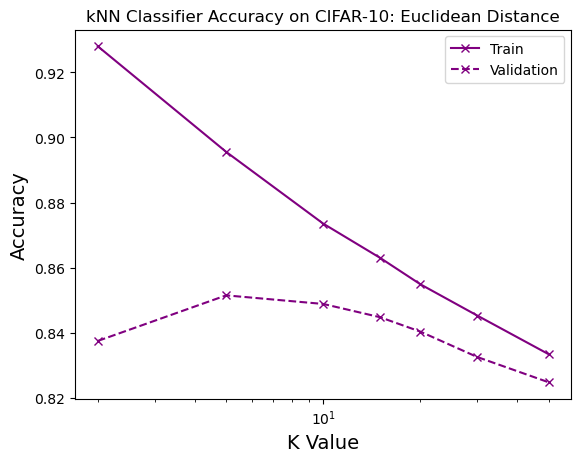

In [18]:
fig, axes = plt.subplots()

axes.semilogx(k_vals, acc_train_eu, linestyle='-', marker='x', color='purple', label='Train')
axes.semilogx(k_vals, acc_val_eu, linestyle='--', marker='x', color='purple', label='Validation')


axes.legend(loc='upper right')
axes.set_xlabel("K Value", fontsize=14)
axes.set_ylabel("Accuracy", fontsize=14)
axes.set_title("kNN Classifier Accuracy on CIFAR-10: Euclidean Distance")
plt.show()

In [33]:
df_eu["Test Accuracy"] = acc_test_eu
df_eu

,K Value,Train Accuracy,Validation Accuracy,Test Accuracy
0,2,0.928000,0.837500,0.843357
1,5,0.895571,0.851500,0.849929
2,10,0.873524,0.848857,0.848786
3,15,0.863024,0.844786,0.844357
4,20,0.854905,0.840357,0.840643
5,30,0.845310,0.832571,0.837500
6,50,0.833405,0.824786,0.827500


In [41]:
df_eu.to_csv('./results/knn_eu.csv', index=False)

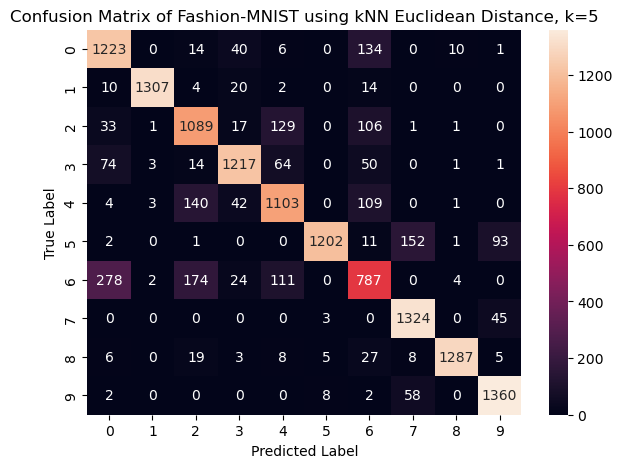

In [35]:
cm_knn = cm(y_pred_eu[1], "kNN Euclidean Distance, k=5")
cm_knn.show()